In [1]:
import numpy as np
import math
import time
import xlrd
import matplotlib.pyplot as plt
from data_extract import *
from data_preprocess import *
import copy


# Data Extraction

In [2]:
gdf_fname = "C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf"
compressed_fname = "S1R1ME.bz2"

t1 = time.time()
HDR, data = read_data(gdf_fname)
seqs_v_class_map = segregate_data_into_classes(HDR, data)
#compress_segregated_data(seqs_v_class_map, compressed_fname)
print("Done processing file in %f s\n" % (time.time() - t1))

# define sampling rate
fs = int(HDR.SampleRate/2)

Finished reading header
Read header of C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf in 0.008986 s

Finished reading data
Read data of C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf in 53.020467 s

Finished segregating data into classes in 0.569508 s

Done processing file in 53.599962 s



# load the channel labels

In [3]:
# Give the location of the file that maps eeg index to channel name 
loc = ("C:/Users/Liangyu/Desktop/BME725/Final Project/ChannelLabel.xlsx") 

# Open the xls file
wb = xlrd.open_workbook(loc) 
sheet = wb.sheet_by_index(0) 

# Remove artifacts

In [4]:
t1 = time.time()

# set parameters
nBins = 20
threshold = 5        # in standard deviation
thresholdSig = 200   # in uV
copyLib = True
disp = False         # True to display the rejected channels

# rejects based on joint probability
rejChanProb = markArtifactJointProb(seqs_v_class_map, nBins, threshold)

# reject based on kurtosis
rejChanKurt = markArtifactKurtosis(seqs_v_class_map, threshold)

# reject based on eeg signal value
rejChanThresh = markArtifactSigVal(seqs_v_class_map, thresholdSig)

# concatenate the index of the rejected channels
rejChan = np.zeros((1,3),dtype=int)
rejChan = np.concatenate((rejChan, rejChanProb), axis=0) if np.size(rejChanProb)>1 else rejChan
rejChan = np.concatenate((rejChan, rejChanKurt), axis=0) if np.size(rejChanKurt)>1 else rejChan
rejChan = np.concatenate((rejChan, rejChanThresh), axis=0) if np.size(rejChanThresh)>1 else rejChan
rejChan = np.delete(rejChan, (0), axis=0)

# set the rejected channels to 0
seqs_v_class_map_noArtifact = rejectArtifact(seqs_v_class_map, rejChan, copyLib, disp)

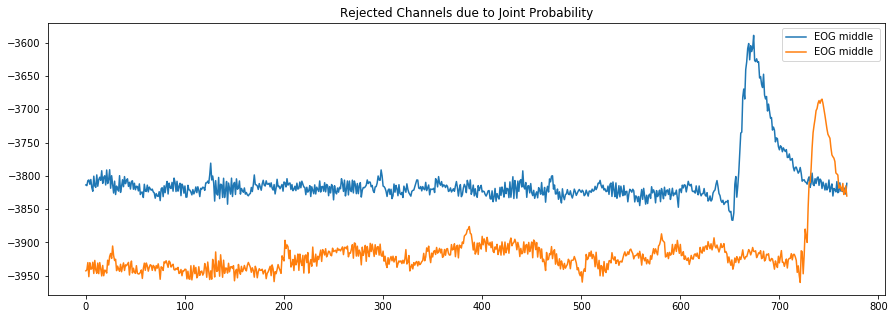

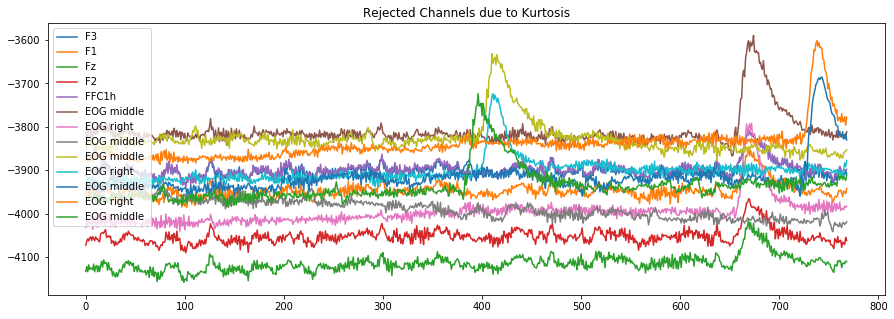

In [5]:
# plot the channels that were rejected due to joint probability
if np.size(rejChanProb)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Joint Probability')
    for i in range(np.shape(rejChanProb)[0]):
        plt.plot(seqs_v_class_map[rejChanProb[i,0]][rejChanProb[i,1]][:,rejChanProb[i,2]], \
                 label=sheet.cell_value(rejChanProb[i,2]+1, 1))
    plt.legend()

# plot the channels that were rejected due to kurtosis
if np.size(rejChanKurt)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Kurtosis')
    for i in range(np.shape(rejChanKurt)[0]):
        plt.plot(seqs_v_class_map[rejChanKurt[i,0]][rejChanKurt[i,1]][:,rejChanKurt[i,2]], \
                 label=sheet.cell_value(rejChanKurt[i,2]+1, 1))
    plt.legend()

# plot the channels that were rejected due to eeg signal value
if np.size(rejChanThresh)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Absolute Deviation from Mean')
    for i in range(np.shape(rejChanThresh)[0]):
        plt.plot(seqs_v_class_map[rejChanThresh[i,0]][rejChanThresh[i,1]][:,rejChanThresh[i,2]])
        plt.legend()

# Window the 1D eeg vector data into time bins

In [6]:
# window size parameters
width = int(fs/4)
nOverlap = int(fs/8)
initTime = 0
finTime = int(fs*3)-nOverlap

# segment the data based into windows
seqs_v_class_map_binned = data_segmentation(seqs_v_class_map_noArtifact, initTime, finTime, width, nOverlap)

# show the old and new array dimensions for class 1
print(np.shape(seqs_v_class_map[1]))
print(np.shape(seqs_v_class_map_binned[1]))

(6, 769, 64)
(6, 23, 64, 64)


# Convert 1D eeg vector to 2D spatial array

In [7]:
# define the mapping of each channel to the r,c values of the mesh (This needs to be changed. I'ts currently just in order)
maps = [(0, 4), (0, 5), (0, 6),\
        (1, 3), (1, 4), (1, 5), (1, 6), (1, 7),\
        (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9),\
        (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9),\
        (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10),\
        (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9),\
        (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9),\
        (7, 3), (7, 4), (7, 5), (7, 6), (7, 7),\
        (8, 4), (8, 5), (8, 6),\
        (9, 5)]
 
# create the mesh
mesh = [ [ "   " for y in range(0,11) ] for x in range(0,10) ] 
for chan in range(1,np.shape(maps)[0]):
    mesh[maps[chan][0]][maps[chan][1]] = sheet.cell_value(chan, 1)

# print the 2D mesh of channels
for x in range(0,10): 
    print(mesh[x])
    
# change the 1D eeg signal to 2D eeg signal based on the defined map
seqs_v_class_map_noArtifact_mesh = data_1D_to_2D(seqs_v_class_map_noArtifact, 10, 11, maps)

# print the size of the new array for the first class
print(np.shape(seqs_v_class_map_noArtifact_mesh[1]))

['   ', '   ', '   ', '   ', '   ', 'F3 ', 'F1 ', '   ', '   ', '   ', '   ']
['   ', '   ', '   ', 'Fz ', 'F2 ', 'F4 ', 'FFC5h ', 'FFC3h ', '   ', '   ', '   ']
['   ', 'FFC1h ', 'FFC2h ', 'FFC4h ', 'FFC6h ', 'FC5 ', 'FC3 ', 'FC1 ', 'FCz ', 'FC2 ', '   ']
['   ', 'FC4 ', 'FC6 ', 'FTT7h ', 'FCC5h ', 'FCC3h ', 'FCC1h ', 'FCC2h ', 'FCC4h ', 'FCC6h ', '   ']
['FTT8h ', 'C5 ', 'C3 ', 'C1 ', 'Cz ', 'C2 ', 'C4 ', 'C6 ', 'TTP7h ', 'CCP5h ', 'CCP3h ']
['   ', 'CCP1h ', 'CCP2h ', 'CCP4h ', 'CCP6h ', 'TTP8h ', 'CP5 ', 'CP3 ', 'CP1 ', 'CPz ', '   ']
['   ', 'CP2 ', 'CP4 ', 'CP6 ', 'CPP5h ', 'CPP3h ', 'CPP1h ', 'CPP2h ', 'CPP4h ', 'CPP6h ', '   ']
['   ', '   ', '   ', 'P3 ', 'P1 ', 'Pz ', 'P2 ', 'P4 ', '   ', '   ', '   ']
['   ', '   ', '   ', '   ', 'PPO1h ', 'PPO2h ', 'EOG left ', '   ', '   ', '   ', '   ']
['   ', '   ', '   ', '   ', '   ', 'EOG middle ', '   ', '   ', '   ', '   ', '   ']
(6, 769, 10, 11)


# Window the 2D eeg array data into time bins

In [8]:
# window size parameters
width = int(fs/4)
nOverlap = int(fs/8)
initTime = 0
finTime = int(fs*3)-nOverlap

# segment the data based into windows
seqs_v_class_map_binned2 = data_segmentation(seqs_v_class_map_noArtifact_mesh, initTime, finTime, width, nOverlap)

# show the old and new array dimensions for class 1
print(np.shape(seqs_v_class_map[1]))
print(np.shape(seqs_v_class_map_binned2[1]))

(6, 769, 64)
(6, 23, 64, 10, 11)


In [9]:
print("Done pre-processing files file in %f s\n" % (time.time() - t1))

Done pre-processing files file in 5.861482 s

